# 1 - install dependencies

In [1]:
import numpy as np
import cv2 
import os
import mediapipe as mp
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import pandas as pd

# 2 - keypoints extractions and drawing

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

num_hand_marks = 21
num_pose_marks = 33


# holistic model process image and return the results as keypoints
def mediapipe_detection(image,model):
    image  = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image  = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image,results
    
def draw_styled_landmarks(image,results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 
    

# read the keypoints and extract them and process them
def extract_keypoints(results):
    # extract pose marks
    if results.pose_landmarks:
        pose = np.array([ [res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark ]).flatten()
    else:
        pose = np.zeros(num_pose_marks*4)
    
    # extract left hand
    if results.left_hand_landmarks:
        left_hand = np.array([ [res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark ]).flatten()
    else:
        left_hand = np.zeros(num_hand_marks*3)
        
        
    # extract right hand
    if results.right_hand_landmarks:
        right_hand = np.array([ [res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark ]).flatten()
    else:
        right_hand = np.zeros(num_hand_marks*3)
    
    return np.concatenate([pose,left_hand,right_hand])
    

# 3 - read and process data

In [5]:
data_path = "../../../data/Datasets/"

train_labels = pd.read_csv(os.path.join(data_path,"train_labels.csv"),names=['sample','id'])
validation_labels = pd.read_csv(os.path.join(data_path,"validation_labels.csv"),names=['sample','id'])
test_labels = pd.read_csv(os.path.join(data_path,"test_labels.csv"),names=['sample','id'])
class_id = pd.read_csv(os.path.join(data_path,"class_id.csv"))


    
train_path = os.path.join(data_path,"train")
val_path = os.path.join(data_path,"val")
test_path = os.path.join(data_path,"test")



In [137]:
train_labels

,sample,id
0,signer0_sample1,41
1,signer0_sample2,104
2,signer0_sample3,205
3,signer0_sample4,26
4,signer0_sample5,191
...,...,...
28137,signer42_sample668,82
28138,signer42_sample669,164
28139,signer42_sample670,215
28140,signer42_sample671,123


In [6]:
def check_file(file_path):
    try:
        f = open(file_path)
        f.close()
        return True
    except IOError:
        return False
    
    

def construct_path(file,path="train"):
    return os.path.join(os.path.join(data_path,path),file+"_color.mp4")
    

### 3.1 collect data that in classes 0,1,2 and available in the data/train directory

In [7]:
n_actions = 5
actions = list(class_id['EN'][:n_actions])

In [8]:
actions

['sister', 'hurry', 'hungry', 'enjoy_your_meal', 'brother']

In [9]:
n_actions = 5
actions = list(class_id['EN'][:n_actions])
actions[-1] = "tree"
actions[-2] = "meal"
dic={}
for i,action in enumerate(actions):
    dic[action]=i

In [10]:
dic

{'sister': 0, 'hurry': 1, 'hungry': 2, 'meal': 3, 'tree': 4}

In [11]:
def get_data(value,file_path,label_name):
    if file_path=="train":
        label_dic = train_labels
    elif file_path=="val":
        label_dic = validation_labels
    elif file_path=="test":
        label_dic = test_labels
        
    
    data =  label_dic[label_dic['id']==value]
    lis =  [construct_path(i,file_path) for i in  (data['sample'])]
    data =  [i for i in lis if check_file(i)]
    return data,[label_name for i in data]
    

    

In [170]:


d = [0,1,2,3,5]

def get_list(d,cat):
    arr_x=[]
    arr_y=[]
    for index,value in enumerate(d):
        
        data,labels = get_data(value,cat,index)
        arr_x.extend(data)
        arr_y.extend(labels)
    return arr_x,arr_y

train_X,train_Y = get_list(d,"train")
val_X,val_Y = get_list(d,"val")
test_X,test_Y = get_list(d,"test")


In [171]:
print(
    len(train_X ),
len(train_Y),
len(val_X ),
len(val_Y),
len(test_X ),
len(test_Y)
)

622 622 98 98 83 83


In [173]:
train_X[-1]

'../../../data/Datasets/train/signer42_sample383_color.mp4'

### 3.2 process videos into frames and label to cateogries

In [174]:


def capture_frames(video_path):
    video = cv2.VideoCapture(video_path)
    video_length = int(video.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    # count = 0
    # frame_rate = video.get(cv2.CAP_PROP_FRAME_COUNT)

    count=0
    frames = []
    while video.isOpened():
      # frame_id = video.get(0)
        ret, frame = video.read()
        
        if not ret:
            continue
        frames.append(frame)
        count += 1
        # If there are no more frames left
        if (count > (video_length-1)):
          # Release the feed
          video.release()
        # if frame_id % math.floor(1) == 0:
        #     file_name = f"{video_path}_frame_{count}.jpg"
        #     count += 1
        #     # print(f"File name: {file_name}")
        #     frames.append(frame)
        #     # cv2.imwrite(file_name, frame)
    video.release()
    return np.array(frames)


def get_frames(video_path,num_frames):
    frames = capture_frames(video_path)
    video_length = len(frames)
    steps = video_length/num_frames
    count=0
    new_frames=[]
    while count<video_length:
        frame = frames[int(count)]
#         frame = cv2.resize(frame, (256, 256))
#         frame =  (frame/255.0).astype(np.float16)
        new_frames.append(frame)
        count+=steps

    s = np.array(new_frames[:num_frames])
    return np.array(new_frames[:num_frames])


In [70]:
def extract_keypoints_video(path,i=-1):
    
    if(i!=-1):
        print(i,end="\r")
    
    if(type(path) == str):
        frames = get_frames(path,20)
    frames = path
    output_key_points=[]
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        for frame in frames:
            image, results = mediapipe_detection(frame, holistic)
            output_key_points.append(extract_keypoints(results))
    return np.array(output_key_points)


    

### 3.3 - extract the keypoints and save them in train

In [177]:
if "train_features:0-20.npy" in os.listdir():
    train_data = np.load("train_features:0-20.npy")
    val_data = np.load("val_features:0-20.npy")
    test_data = np.load("test_features:0-20.npy")
    train_labels = np.load("train_labels:0-20.npy")
    val_labels = np.load("val_labels:0-20.npy")
    test_labels = np.load("test_labels:0-20.npy")
else:
    train = np.array([extract_keypoints_video(path,f'Train iteration : {i+1}/{len(train_X)}') for i,path in enumerate(train_X) ])
    np.save('train_features:0-20.npy', train) 
    print("Training Finished")
    val = np.array([extract_keypoints_video(path,f'Valdiation iteration : {i+1}/{len(val_X)}') for i,path in enumerate(val_X) ])
    np.save('val_features:0-20.npy', val) 
    print("Validation Finished")
    test = np.array([extract_keypoints_video(path,f'Test iteration : {i+1}/{len(test_X)}') for i,path in enumerate(test_X) ])
    np.save('test_features:0-20.npy', test)
    print("Test Finished")
    np.save("train_labels:0-20.npy",np.array(train_Y))
    np.save("val_labels:0-20.npy",np.array(val_Y))
    np.save("test_labels:0-20.npy",np.array(test_Y))

In [178]:
print(
train_data.shape,
    train_labels.shape,
    val_data.shape,
    val_labels.shape,
    test_data.shape,
    test_labels.shape
    
)

(622, 20, 258) (622,) (98, 20, 258) (98,) (83, 20, 258) (83,)


### 3.4 shuffle the data

In [179]:
perm = np.random.permutation(len(train))

train_X = train_data[perm]
train_Y = train_labels[perm]
val_X = val_data
val_Y = val_labels
test_X = test_data
test_Y = test_labels


In [180]:
print(
train_X.shape,
train_Y.shape,
val_X.shape,
val_Y.shape,
test_X.shape,
test_Y.shape,
)

(622, 20, 258) (622,) (98, 20, 258) (98,) (83, 20, 258) (83,)


# 4 - build and train the model

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Input,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint,EarlyStopping


tb_callback = TensorBoard(log_dir=os.path.join('Logs'))
checkpoint = ModelCheckpoint("best_model_v2.h5", monitor='loss', verbose=0,
    save_best_only=True, mode='auto', save_freq=1)
earlyStopping = EarlyStopping(monitor='loss', patience=20)

In [12]:
def first_model():
    input_layer = Input(shape=(20,258))
    layer = LSTM(64,return_sequences=True,activation="relu")(input_layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = LSTM(256,return_sequences=True,activation="relu")(layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = LSTM(64,return_sequences=False,activation="relu")(layer)
    layer = Dense(64,activation="relu")(layer)
    layer = Dense(32,activation="relu")(layer)
    layer = Dense(len(actions),activation="softmax")(layer)

    model = Model(inputs=input_layer,outputs=layer)
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model


def second_model():
    input_layer = Input(shape=(20,258))
    layer = LSTM(64,return_sequences=True,activation="relu")(input_layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = Dropout(0.3)(layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = Dropout(0.3)(layer)
    layer = LSTM(64,return_sequences=False,activation="relu")(layer)
    layer = Dense(64,activation="relu")(layer)
    layer = Dense(32,activation="relu")(layer)
    layer = Dense(len(actions),activation="softmax")(layer)

    model = Model(inputs=input_layer,outputs=layer)
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

def third_model():
    input_layer = Input(shape=(20,258))
    layer = LSTM(64,return_sequences=True,activation="relu")(input_layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = LSTM(96,return_sequences=False,activation="relu")(layer)
    layer = Dense(64,activation="relu")(layer)
    layer = Dense(32,activation="relu")(layer)
    layer = Dense(len(actions),activation="softmax")(layer)

#     optimizer = tf.keras.optimizers.Nadam(learning_rate=0.002,
#                              beta_1=0.9,
#                              beta_2=0.999, 
#                              epsilon=1e-08,
#                              schedule_decay=0.004)
    
    model = Model(inputs=input_layer,outputs=layer)
    model.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


model = third_model()

In [13]:
# model.load_weights('best_model.h5')

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 258)]         0         
                                                                 
 lstm_3 (LSTM)               (None, 20, 64)            82688     
                                                                 
 lstm_4 (LSTM)               (None, 20, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 96)                86400     
                                                                 
 dense_2 (Dense)             (None, 64)                6208      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 5)                 165   

In [186]:
history = model.fit(train_X, train_Y, epochs=400, callbacks=[tb_callback,checkpoint,earlyStopping],validation_data=(val_X,val_Y))

Epoch 1/400
20/20 [==============================] - 3s 70ms/step - loss: 1.5656 - accuracy: 0.2428 - val_loss: 1.3329 - val_accuracy: 0.3776
Epoch 2/400
20/20 [==============================] - 1s 50ms/step - loss: 1.5866 - accuracy: 0.3617 - val_loss: 1.5329 - val_accuracy: 0.2143
Epoch 3/400
20/20 [==============================] - 1s 49ms/step - loss: 1.5519 - accuracy: 0.3151 - val_loss: 1.4708 - val_accuracy: 0.3776
Epoch 4/400
20/20 [==============================] - 1s 63ms/step - loss: 1.2567 - accuracy: 0.4228 - val_loss: 1.1000 - val_accuracy: 0.4694
Epoch 5/400
20/20 [==============================] - 1s 53ms/step - loss: 1.3513 - accuracy: 0.4277 - val_loss: 1.5159 - val_accuracy: 0.3776
Epoch 6/400
20/20 [==============================] - 1s 47ms/step - loss: 1.4730 - accuracy: 0.3264 - val_loss: 1.4014 - val_accuracy: 0.3673
Epoch 7/400
20/20 [==============================] - 1s 47ms/step - loss: 1.1666 - accuracy: 0.3971 - val_loss: 1.1647 - val_accuracy: 0.5000
Epoch 

20/20 [==============================] - 1s 49ms/step - loss: 0.2939 - accuracy: 0.8987 - val_loss: 0.3017 - val_accuracy: 0.9184
Epoch 116/400
20/20 [==============================] - 1s 50ms/step - loss: 0.1650 - accuracy: 0.9534 - val_loss: 0.2974 - val_accuracy: 0.9490
Epoch 117/400
20/20 [==============================] - 1s 49ms/step - loss: 0.0549 - accuracy: 0.9823 - val_loss: 0.1570 - val_accuracy: 0.9694
Epoch 118/400
20/20 [==============================] - 1s 48ms/step - loss: 0.0220 - accuracy: 0.9984 - val_loss: 0.2201 - val_accuracy: 0.9592
Epoch 119/400
20/20 [==============================] - 1s 49ms/step - loss: 0.0296 - accuracy: 0.9871 - val_loss: 0.2016 - val_accuracy: 0.9694
Epoch 120/400
20/20 [==============================] - 1s 48ms/step - loss: 0.0264 - accuracy: 0.9904 - val_loss: 0.2483 - val_accuracy: 0.9592
Epoch 121/400
20/20 [==============================] - 1s 48ms/step - loss: 0.0287 - accuracy: 0.9855 - val_loss: 0.2299 - val_accuracy: 0.9592
Epoch 

Epoch 172/400
20/20 [==============================] - 1s 49ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.2758 - val_accuracy: 0.9592
Epoch 173/400
20/20 [==============================] - 1s 49ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.3157 - val_accuracy: 0.9592


In [187]:
print(history.history.keys())
# summarize history for accuracy



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


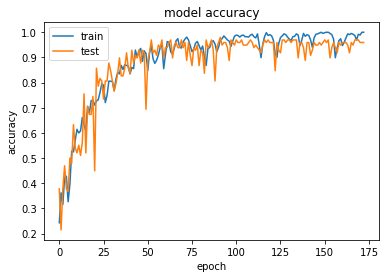

In [188]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

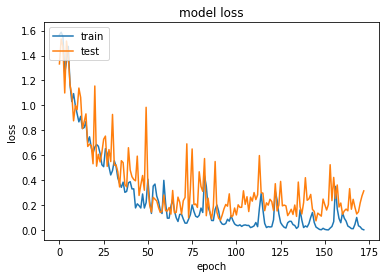

In [189]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [204]:
m2.evaluate(train_X,train_Y)

20/20 [==============================] - 0s 7ms/step - loss: 0.0035 - accuracy: 1.0000


[0.0034555569291114807, 1.0]

In [200]:
m2 = third_model()
m2.load_weights('best_model_v2.h5')

In [15]:
model.load_weights('best_model.h5')

# 5 - test in real time

In [41]:

def view_probability(res, actions, image):
    #output_frame = input_frame.copy()
    
    output_frame = image
    
    if(type(res)==list or type(res)==np.ndarray):
        max_prob_index = np.argmax(res)
        max_prob = res[max_prob_index]
        text = f'{actions[max_prob_index]} - {max_prob:.3f}'
    else:
        text = "not signing"
    
    
    cv2.rectangle(output_frame, (0,0), (640, 40), (0,255,0), -1)
    cv2.putText(output_frame, text, (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame



def view_sentence(sentence,image):
    # output_frame = image.copy()
    output_frame = image
    
    cv2.rectangle(output_frame, (0,430), (640, 480), (255, 0, 0), -1)
    cv2.putText(output_frame, ' '.join(sentence), (3,460), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame


def compare_frames(prev_frame,current_frame,threshold):
    if(type(prev_frame) == np.ndarray ):
        diff = cv2.absdiff(prev_frame, current_frame)
        s = diff.sum()
        if(s > threshold):
            return True
        
    return False
    
def evaluate_list_comparisons(s):
    
    if(sum(s)>=2):
        return True
    return False

In [45]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 

last_comparisons = []
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)
prev_frame = None
while cap.isOpened():

    ret, frame = cap.read()
    if(not ret):break
        
        
        
    comparison_result = compare_frames(prev_frame,frame,4000000)
    prev_frame = frame
    
    last_comparisons.append(int(comparison_result))
    last_comparisons = last_comparisons[-2:]
    
    
    

    image, results = mediapipe_detection(frame, holistic)
    draw_styled_landmarks(image, results)

    # 2. Prediction logic
    
    
    if(evaluate_list_comparisons(last_comparisons)):
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-20:]

        if len(sequence) == 20:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))


        #3. Viz logic
            if np.unique(predictions[-2:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 

                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]
    else:
        res = None


    image = view_probability(res, actions, image)
    image = view_sentence(sentence,image)
    


    cv2.imshow('OpenCV Feed', image)

    # Break
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
cap.release()

In [ ]:
cv2.destroyAllWindows()

# 6-read video and predict it (for slower models)

In [95]:
def read_video_camera(n_frames,duration=3):
    import time
    
    frames = []
    
    cap = cv2.VideoCapture(0)
    start_time = time.time()
    while cap.isOpened():
        ret, frame = cap.read()
        if(not ret):break
        
        cv2.imshow("frame",frame)
        
        cv2.waitKey(20)
            
        frames.append(frame)
        if(time.time()-start_time > duration):
            break
    cap.release()
    cv2.destroyAllWindows()
    print(len(frames),n_frames)
    steps = len(frames)/n_frames
    count=0
    new_frames=[]
    while count < len(frames):
        frame = frames[int(count)]
        new_frames.append(frame)
        count+=steps
        
    
    return np.array(new_frames[:n_frames])
    
    
def view_video(video):
    for frame in video:
        cv2.imshow("frame",frame)
        cv2.waitKey(100)
    cv2.destroyAllWindows()
    
    
    

        


### read the video from Webcam

In [136]:
video = read_video_camera(n_frames=20,duration=3) # duration is for the human to take his time making the move

74 20


### view the video

In [132]:
view_video(video)

### make prediction

In [137]:
key_points = extract_keypoints_video(video)

In [138]:
predection_array = model.predict(np.expand_dims(key_points, axis=0))[0]
predection_id = np.argmax(predection_array)
predection_label = actions[predection_id]
predection_prob = predection_array[predection_id]
print(predection_label,predection_prob)


hurry 0.99999964


In [131]:
predection_array

array([0.00219467, 0.09042753, 0.15158355, 0.75396156, 0.00183264],
      dtype=float32)

In [104]:
actions

['sister', 'hurry', 'hungry', 'meal', 'tree']